## GA3C-CADRL
#### GPU/CPU Asynchronous Advantage Actor-Critic for Collision Avoidance with Deep Reinforcement Learning
Michael Everett, Yu Fan Chen, and Jonathan P. How<br>
2018 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS)<br>
Paper: https://arxiv.org/abs/1805.01956<br>
Video: https://www.youtube.com/watch?v=XHoXkWLhwYQ<br>

**Objective:** This goal of this notebook is to explain how to use our code, enabling other researchers to test and compare against the results presented in the paper. After reading this notebook, it should also be clear how our code could be implemented on your own system (i.e. what format you should provide as input, and what information you'll get as output)

## Create an instance of an Agent
The most important class is Agent, which has attributes such as radius and position, and methods such as find_next_action. The environment is made up of several Agents.

In [1]:
import agent
import network
import util
import numpy as np

2025-11-05 17:46:08.899611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-05 17:46:08.899899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 17:46:08.937819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 17:46:09.779935: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

### Load trained network

In [2]:
possible_actions = network.Actions()
num_actions = possible_actions.num_actions
nn = network.NetworkVP_rnn(network.Config.DEVICE, 'network', num_actions)
nn.simple_load('../checkpoints/network_01900000')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


E0000 00:00:1762361196.312493  737833 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762361196.326325  737833 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
import tensorflow
tensorflow.python.training.checkpoint_utils.list_variables("../checkpoints/network_01900000")

### Set current state of host agent

In [3]:
start_x = 2
start_y = 5
goal_x = 3
goal_y = 2
radius = 0.5
pref_speed = 1.2
heading_angle = 0.
index = 0
v_x = 0
v_y = 0

host_agent = agent.Agent(start_x, start_y, goal_x, goal_y, 
                         radius=radius, pref_speed=pref_speed, initial_heading=heading_angle,
                         id=index)
host_agent.vel_global_frame = np.array([v_x, v_y])

### Set current state of other agents

In [4]:
# Sample observation data in a format easily generated from sensors
other_agents_x = [-1,-2,-3]
other_agents_y = [2,3,4]
other_agents_r = [0.5, 0.4, 0.3]
other_agents_vx = [1.0, 0.6, 0.2]
other_agents_vy = [0.0, 0.6, 0.8]
num_other_agents = len(other_agents_x)

# Create Agent objects for each observed dynamic obstacle
other_agents = []
for i in range(num_other_agents):
    x = other_agents_x[i]; y = other_agents_y[i]
    v_x = other_agents_vx[i]; v_y = other_agents_vy[i]
    radius = other_agents_r[i]
    
    other_agent = agent.Agent(x, y, goal_x, goal_y, radius=radius, id=i+1)
    other_agent.vel_global_frame = np.array([v_x, v_y])
    other_agents.append(other_agent)

### Convert agent states into observation vector

In [5]:
obs = host_agent.observe(other_agents)[1:]
obs = np.expand_dims(obs, axis=0)

### Plot observation in agent's ego frame (goal at origin, agent on x-axis)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


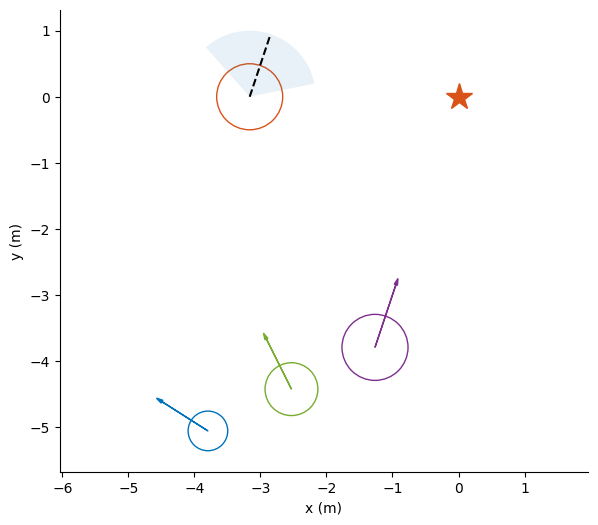

In [6]:
util.plot_current_state_ego_frame(obs)
# Dashed line shows ego agent's current heading (in ego frame)
# Blue wedge shows bounds of possible new heading angles

### Query the policy based on observation vector

In [10]:
predictions = nn.predict_p(obs)[0]
raw_action = possible_actions.actions[np.argmax(predictions)]
action = np.array([host_agent.pref_speed*raw_action[0], util.wrap(raw_action[1] + host_agent.heading_global_frame)])
print("action ",action)
# Action contains: [new forward speed, change in heading angle]

action  [1.2        0.26179939]
